In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

In [159]:
def generate_synthetic_fico_data(n=1000):
    np.random.seed(42)  # For reproducibility
    
    # Simulate Payment History
    # A mix of positive and negative factors
    payment_history = np.random.normal(700, 200, n) - np.random.choice([0, 20, 50, 100], n, p=[0.7, 0.15, 0.1, 0.05])
    
    # Simulate Amounts Owed
    # Influence of credit utilization and total balance
    amounts_owed = 850 - np.random.beta(2, 5, n) * 500  # Beta distribution for utilization skew
    
    # Simulate Length of Credit History
    # Older accounts generally mean higher scores
    length_of_credit_history = np.random.choice(range(300, 850), n, replace=True)
    
    # Simulate Credit Mix
    # More diverse credit types yield higher scores
    credit_mix = np.random.choice(range(600, 850), n, replace=True)
    
    # Simulate New Credit
    # Recent credit activities lower the score
    new_credit = 700 + np.random.gamma(3, 100, n)
    # new_credit = 850 - np.random.gamma(2, 100, n)
    
    # Combine into DataFrame
    data = {
        'Payment History': payment_history,
        'Amounts Owed': amounts_owed,
        'Length of Credit History': length_of_credit_history,
        'Credit Mix': credit_mix,
        'New Credit': new_credit
    }
    df = pd.DataFrame(data) # Divide by 100 to scale down the values
    
    # Calculate FICO Score with given weights
    weights = {'Payment History': 0.45, 'Amounts Owed': 0.20, 'Length of Credit History': 0.15, 'Credit Mix': 0.10, 'New Credit': 0.10}
    df['FICO Score'] = df.apply(lambda row: sum(row[feature] * weight for feature, weight in weights.items()), axis=1)
    
    return df


def w(beta, gamma):
    """
    Applies the transformation to beta.
    
    Args:
    beta (float): The input weight.
    gamma (float): The gamma parameter for the transformation.

    Returns:
    float: The transformed weight.
    """
    return np.exp(-(-np.log(beta))**gamma)


def behavioral(weights, gamma):
    """
    Modifies the weights according to the specified formula.
    
    Args:
    weights (np.array): Original model weights.
    gamma (float): The gamma parameter for the transformation.

    Returns:
    np.array: Modified weights reflecting behavioral adjustments.
    """
    sorted_indices = np.argsort(weights)  # Sort indices of weights
    sorted_weights = weights[sorted_indices]  # Sort weights
    transformed_weights = [w(beta, gamma) for beta in sorted_weights]
    
    perceived_weights = np.zeros_like(weights)
    for i in range(len(weights)):
        sum_current = sum(transformed_weights[i:])
        sum_next = sum(transformed_weights[i+1:]) if i+1 < len(weights) else 0
        perceived_weights[sorted_indices[i]] = sum_current - sum_next

    return perceived_weights

In [160]:
# Generate the dataset
df = generate_synthetic_fico_data()
fico_df = df.copy()

In [161]:
# Sigmoid function to calculate probability
def sigmoid(x):
    return 1 / (1 + np.exp(-0.8 * (x/10 - 65)))

# Calculate the approval probability for each individual
fico_df['Approval Probability'] = sigmoid(fico_df['FICO Score'])

# Assign "true" labels based on approval probability being above a random threshold
# This introduces randomness in the assignment, making some borderline cases get approved or denied
fico_df['True Label'] = (fico_df['Approval Probability'] >= np.random.rand(fico_df.shape[0])).astype(int)

fico_df.head(10)

,Payment History,Amounts Owed,Length of Credit History,Credit Mix,New Credit,FICO Score,Approval Probability,True Label
0,799.342831,706.411569,437,683,1492.022358,784.038823,0.999978,1
1,672.347140,719.320818,569,713,897.075284,692.777905,0.968392,1
2,829.537708,797.272891,849,822,993.440612,841.640608,1.000000,1
3,984.605971,680.290205,695,731,1203.490561,876.829784,1.000000,1
4,653.169325,816.627977,763,845,1010.284932,757.230285,0.999812,1
5,603.172609,652.577607,749,765,767.954085,667.588604,0.803306,1
6,1015.842563,764.920133,630,844,922.360672,881.249247,1.000000,1
7,853.486946,504.395331,552,790,1008.716148,747.619807,0.999594,1
8,586.105123,764.917478,584,774,1320.897155,713.820516,0.993974,1
9,758.512009,720.170964,573,600,983.934232,729.708020,0.998302,1


In [162]:
def logistic_regression_with_sum_constraint(X, y):
    """
    Train logistic regression model with the constraint that coefficients sum to 1.
    Args:
    X (pd.DataFrame): Feature dataframe.
    y (pd.Series): Target vector.

    Returns:
    tuple: (coefficients, threshold)
    """
    n_features = X.shape[1]
    
    # Coefficients (betas) of the logistic regression model
    beta = cp.Variable(n_features)
    
    # Intercept term
    intercept = cp.Variable()
    
    # Logistic regression model expression
    log_likelihood = cp.sum(cp.multiply(y.values, X.values @ beta + intercept) - cp.logistic(X.values @ beta + intercept))
    
    # Constraints:
    # 1. Sum of beta_i should be 1
    # 2. Each beta_i should be between 0 and 1
    constraints = [
        cp.sum(beta) == 1,
        # beta >= 0,
        # beta <= 1
    ]
    
    # Objective function to maximize the log-likelihood (minimize the negative log-likelihood)
    objective = cp.Maximize(log_likelihood)
    
    # Define the problem
    prob = cp.Problem(objective, constraints)
    
    # Solve the problem
    prob.solve()
    
    # Return the optimized beta and intercept
    return beta.value, intercept.value

# Example usage to get beta and threshold
X = pd.DataFrame([[0.1, 0.2], [0.4, 0.5], [0.7, 0.8], [0.3, 0.6], [0.5, 0.9]], columns=['Feature1', 'Feature2'])
y = pd.Series([0, 1, 0, 0, 1])

beta, threshold = logistic_regression_with_sum_constraint(X, y)
print("Beta coefficients:", beta)
print("Threshold:", threshold)


Beta coefficients: [-4.2427172  5.2427172]
Threshold: -1.8905620930419362


In [163]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Example dataset loading
# Assuming 'FICO Score' is not used as a feature directly in the model training
X = fico_df[['Payment History', 'Amounts Owed', 'Length of Credit History', 'Credit Mix', 'New Credit']]  # model features
y = fico_df['True Label']  # the target variable

# Splitting the dataset
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=42)

# normal logreg
# model = LogisticRegression()

# Train the logistic regression model
beta, threshold = logistic_regression_with_sum_constraint(X_train, y_train)
print("Beta coefficients:", beta)
print("Threshold:", threshold)

# print a few rows of the dataset with predictions and true labels
predictions = (X_test.values @ beta + threshold) > 0  
results = pd.DataFrame({'Prediction': predictions, 'True Label': y_test})
results.head(10)

Beta coefficients: [0.39212244 0.21467826 0.15406656 0.14213006 0.09700268]
Threshold: -661.1366701090858


,Prediction,True Label
521,True,1
737,True,1
740,False,0
660,True,1
411,False,0
678,True,1
626,True,0
513,True,1
859,True,1
136,False,0


In [164]:
# feature names
feature_names = X.columns

# feature weights
coefficients = beta

# Printing feature weights
print("Feature weights:")
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef:.4f}")

    # print perceived weights
perceived_weights = behavioral(coefficients, gamma=0.5)
print("\nPerceived Feature weights:")
for feature, coef in zip(feature_names, perceived_weights):
    print(f"{feature}: {coef:.4f}")

Feature weights:
Payment History: 0.3921
Amounts Owed: 0.2147
Length of Credit History: 0.1541
Credit Mix: 0.1421
New Credit: 0.0970

Perceived Feature weights:
Payment History: 0.3800
Amounts Owed: 0.2893
Length of Credit History: 0.2547
Credit Mix: 0.2474
New Credit: 0.2171


# Optimization

In [165]:
import cvxpy as cp
import numpy as np

def classifier(x, beta, threshold):
    """
    Logistic regression classifier.
    
    Args:
    x : np.array
        Feature vector of the agent.
    beta : np.array
        Weights of the classifier.
    threshold : float
        Threshold for classification.
    
    Returns:
    int
        1 if the agent is classified as positive, 0 otherwise.
    """
    prediction = (x @ beta + threshold) > 0
    return int(prediction)

def cost_function(z, x_0):
    """
    Cost function based on norm-2 distance.
    
    Args:
    z : np.array
        Manipulated feature vector.
    x_0 : np.array
        Original feature vector.
    
    Returns:
    float
        Cost of manipulation.
    """
    return np.linalg.norm(z - x_0)


def agent_optimization(x_0, beta, threshold, mode='actual', gamma=0.5):
    """
    Solve the agent's optimization problem.
    
    Args:
    x_0 : np.array
        Original feature vector.
    beta : np.array
        Weights of the classifier.
    threshold : float
        Threshold for classification.
    R : float
        Reward for being classified as positive.
    mode : str
        Mode of optimization ('actual' or 'perceived').
    gamma : float
        Gamma parameter for behavioral.
    
    Returns:
    np.array
        Optimized feature vector if conditions are met, otherwise the original feature vector.
    """
    if mode == 'actual':
        weights = beta
    elif mode == 'perceived':
        weights = behavioral(beta, gamma)
    else:
        raise ValueError("Mode should be 'actual' or 'perceived'.")

    z = cp.Variable(len(x_0))
    cost = cp.norm(z - x_0, 2)
    eps = 1e-5
    assumed_prediction = cp.sum(cp.multiply(weights, z)) + threshold
    constraints = [assumed_prediction >= eps]
    
    prob = cp.Problem(cp.Minimize(cost), constraints)
    # prob.solve(solver=cp.ECOS)
    prob.solve()
    
    optimized_features = z.value

    return optimized_features


In [166]:
B = 10
beta, threshold = logistic_regression_with_sum_constraint(X_train, y_train)
perceived_weights = behavioral(beta, gamma=0.5)

X_nb = X.copy()
X_b = X.copy()

# Find the agents in X that are closer than B to the decision boundary
# The ones that are closer than B to the decision boundary and classified as negative will optimize
for index_nb, row_nb in X_nb.iterrows():
    if abs(row_nb @ beta + threshold) < B:
        if not classifier(row_nb.values, beta, threshold):
            X_nb.loc[index_nb] = agent_optimization(row_nb.values, beta, threshold, mode='actual')


for index_b, row_b in X_b.iterrows():
    if abs(row_b @ beta + threshold) < B:
        if not classifier(row_b.values, beta, threshold):
            X_b.loc[index_b] = agent_optimization(row_b.values, beta, threshold, mode='actual')

/var/folders/hs/y116vr4j4yg5fcthw_l99c5r0000gn/T/ipykernel_36740/4167810970.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '439.60376355950115' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_nb.loc[index_nb] = agent_optimization(row_nb.values, beta, threshold, mode='actual')
/var/folders/hs/y116vr4j4yg5fcthw_l99c5r0000gn/T/ipykernel_36740/4167810970.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '646.2470810922018' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_nb.loc[index_nb] = agent_optimization(row_nb.values, beta, threshold, mode='actual')
/var/folders/hs/y116vr4j4yg5fcthw_l99c5r0000gn/T/ipykernel_36740/4167810970.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future

In [167]:
print(X.columns)

Index(['Payment History', 'Amounts Owed', 'Length of Credit History',
       'Credit Mix', 'New Credit'],
      dtype='object')


Before optimization:
True positive: 666
False positive: 59
Firm's payoff: 607

After optimization (Non-Behavioral):
True positive: 721
False positive: 183
Firm's payoff: 538

After optimization (Behavioral):
True positive: 710
False positive: 125
Firm's payoff: 585


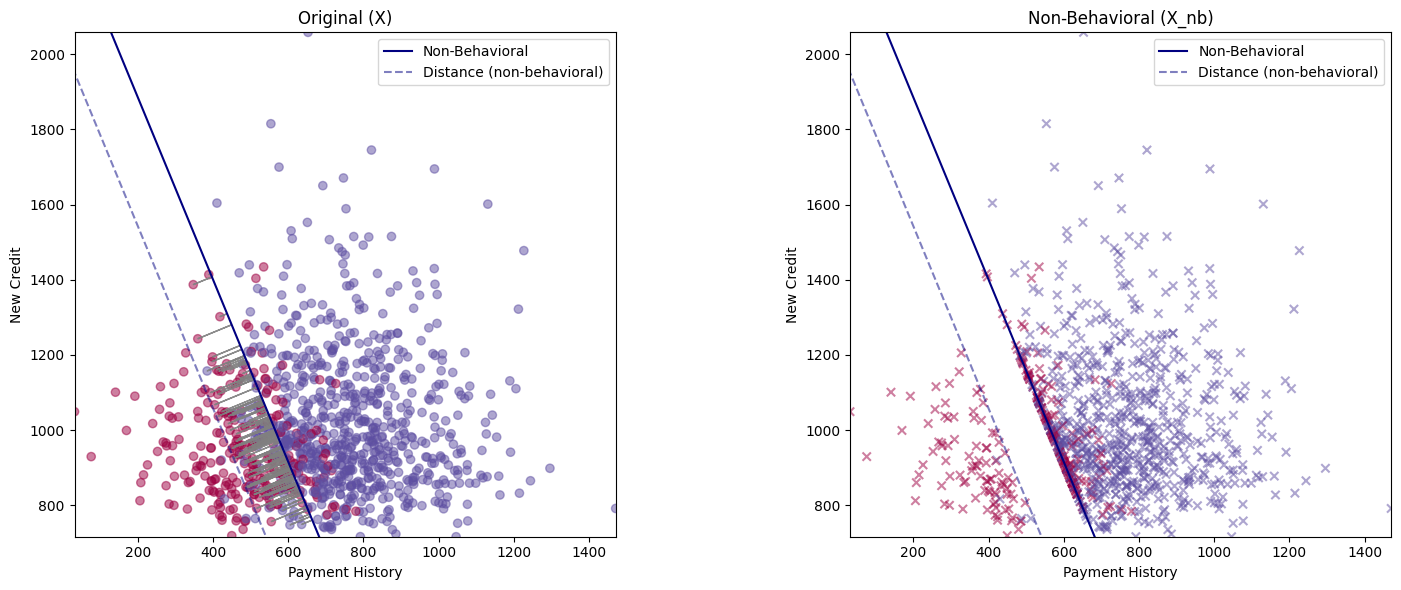

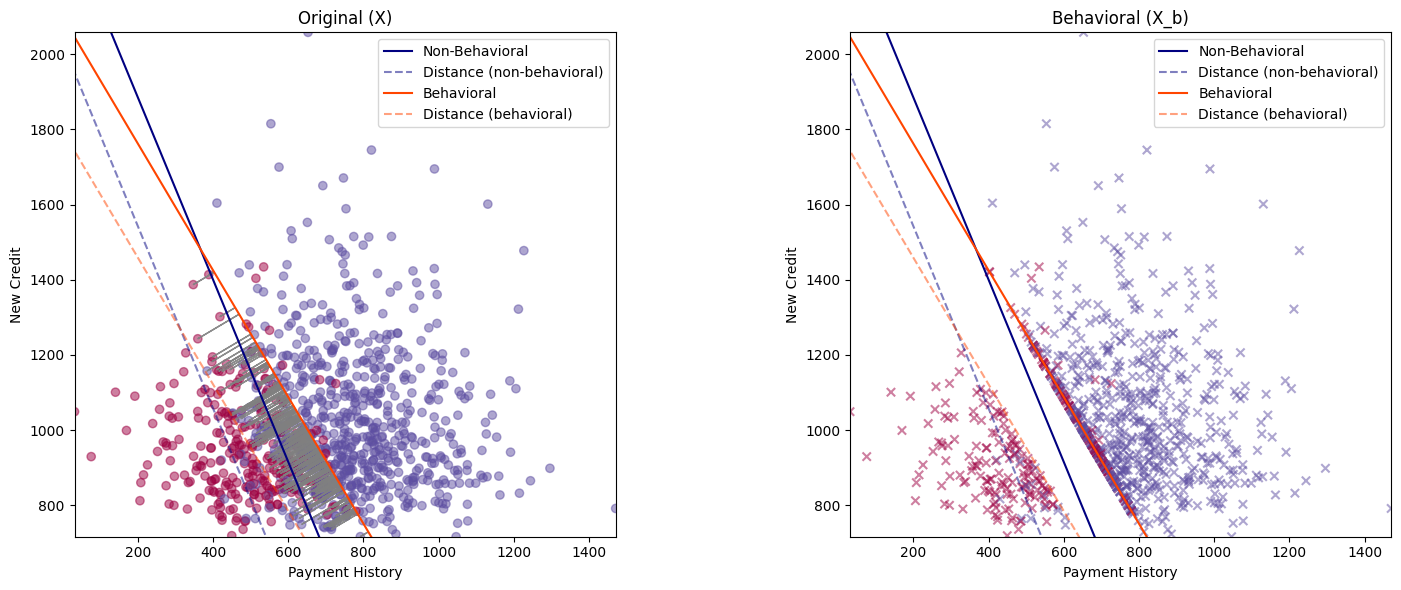

Original Beta coefficients: [0.70788471 0.29211528]
Original Threshold: -692.2274883346097

Beta coefficients (Non-Behavioral): [0.71481866 0.28518132]
Threshold (Non-Behavioral): -692.9850768855727

Beta coefficients (Behavioral): [0.63222615 0.36777384]
Threshold (Behavioral): -779.7754392978748


In [169]:
B = 100
gamma_vis = 0.5

feature1='Payment History'
feature2='New Credit'

X_vis = fico_df[[feature1, feature2]]
y_vis = fico_df['True Label']

beta_vis, threshold_vis = logistic_regression_with_sum_constraint(X_vis, y_vis)
perceived_weights_vis = behavioral(beta_vis, gamma=gamma_vis)

X_nb_vis = X_vis.copy()
X_b_vis = X_vis.copy()

# Find the agents in X that are closer than B to the decision boundary
# The ones that are closer than B to the decision boundary and classified as negative will optimize
for index_nb, row_nb in X_nb_vis.iterrows():
    if abs((row_nb @ beta_vis) + threshold_vis) <= B:
        if not classifier(row_nb.values, beta_vis, threshold_vis):
            X_nb_vis.loc[index_nb] = agent_optimization(row_nb.values, beta_vis, threshold_vis, mode='actual')


for index_b, row_b in X_b_vis.iterrows():
    if abs((row_b @ perceived_weights_vis) + threshold_vis) <= B:
        if not classifier(row_b.values, perceived_weights_vis, threshold_vis):
            X_b_vis.loc[index_b] = agent_optimization(row_b.values, beta_vis, threshold_vis, mode='perceived', gamma=gamma_vis)

# firm's payoff = True positive - False positive (printing for each case, X_nb_vis, X_b_vis, X_vis)

print("Before optimization:")
TP = 0
FP = 0
for index, row in X_vis.iterrows():
    TP += classifier(row.values, beta_vis, threshold_vis) and y_vis.loc[index]
    FP += classifier(row.values, beta_vis, threshold_vis) and not y_vis.loc[index]   

firm_payoff = TP - FP
print(f"True positive: {TP}")
print(f"False positive: {FP}")
print(f"Firm's payoff: {firm_payoff}")


print("\nAfter optimization (Non-Behavioral):")
TP_nb = 0
FP_nb = 0
for index, row in X_nb_vis.iterrows():
    TP_nb += classifier(row.values, beta_vis, threshold_vis) and y_vis.loc[index]
    FP_nb += classifier(row.values, beta_vis, threshold_vis) and not y_vis.loc[index]

firm_payoff_nb = TP_nb - FP_nb
print(f"True positive: {TP_nb}")
print(f"False positive: {FP_nb}")
print(f"Firm's payoff: {firm_payoff_nb}")

print("\nAfter optimization (Behavioral):")
TP_b = 0
FP_b = 0
for index, row in X_b_vis.iterrows():
    TP_b += classifier(row.values, beta_vis, threshold_vis) and y_vis.loc[index]
    FP_b += classifier(row.values, beta_vis, threshold_vis) and not y_vis.loc[index]

firm_payoff_b = TP_b - FP_b
print(f"True positive: {TP_b}")
print(f"False positive: {FP_b}")
print(f"Firm's payoff: {firm_payoff_b}")


# Function to create side-by-side scatter plots with movement arrows
def create_side_by_side_plots_with_arrows(dataset1, dataset2, labels, title1, title2, beta, threshold, B, gamma, feature1=feature1, feature2=feature2, mode='NB'):
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    beta_vis = beta
    threshold_vis = threshold
    gamma_vis = gamma
    
    # Scatter plot for dataset1
    axs[0].scatter(dataset1[feature1], dataset1[feature2], c=labels, cmap='Spectral', alpha=0.5)
    axs[0].set_xlabel(feature1)
    axs[0].set_ylabel(feature2)
    axs[0].set_title(title1)

    # plot the line separating the two classes
    x_vals = np.array(axs[0].get_xlim())
    y_vals_nb = -(threshold_vis + beta_vis[0] * x_vals) / beta_vis[1]
    axs[0].plot(x_vals, y_vals_nb, color='navy', label='Non-Behavioral')
    # plot y_vals - B
    y_vals_nb = -(threshold_vis + beta_vis[0] * x_vals + B) / beta_vis[1]
    axs[0].plot(x_vals, y_vals_nb, '--', color='navy', label='Distance (non-behavioral)', alpha=0.5)
    
    if mode == 'B':
        # plot the line separating the two classes
        perceived_weights_vis = behavioral(beta_vis, gamma=gamma_vis)
        y_vals_b = -(threshold_vis + perceived_weights_vis[0] * x_vals) / perceived_weights_vis[1]
        axs[0].plot(x_vals, y_vals_b, color='orangered', label='Behavioral')
        # plot y_vals - B
        y_vals_b = -(threshold_vis + perceived_weights_vis[0] * x_vals + B) / perceived_weights_vis[1]
        axs[0].plot(x_vals, y_vals_b, '--', color='orangered', label='Distance (behavioral)', alpha=0.5)
    
    

    # Scatter plot for dataset2
    axs[1].scatter(dataset2[feature1], dataset2[feature2], c=labels,  cmap='Spectral', alpha=0.5, marker='x')
    axs[1].set_xlabel(feature1)
    axs[1].set_ylabel(feature2)
    axs[1].set_title(title2)

    # plot the line separating the two classes
    x_vals = np.array(axs[1].get_xlim())
    y_vals_nb = -(threshold_vis + beta_vis[0] * x_vals) / beta_vis[1]
    axs[1].plot(x_vals, y_vals_nb, color='navy', label='Non-Behavioral')
    # plot y_vals - B
    y_vals_nb_B = -(threshold_vis + beta_vis[0] * x_vals + B) / beta_vis[1]
    axs[1].plot(x_vals, y_vals_nb_B, '--', color='navy', label='Distance (non-behavioral)', alpha=0.5)
    
    if mode == 'B':
        # plot the line separating the two classes
        perceived_weights_vis = behavioral(beta_vis, gamma=gamma_vis)
        y_vals_b = -(threshold_vis + perceived_weights_vis[0] * x_vals) / perceived_weights_vis[1]
        axs[1].plot(x_vals, y_vals_b, color='orangered', label='Behavioral')
        # plot y_vals - B
        y_vals_b_B = -(threshold_vis + perceived_weights_vis[0] * x_vals + B) / perceived_weights_vis[1]
        axs[1].plot(x_vals, y_vals_b_B, '--', color='orangered', label='Distance (behavioral)', alpha=0.5)

    axs[0].legend()
    axs[1].legend()

    # equal scaling
    axs[0].set_aspect('equal', adjustable='box')
    axs[1].set_aspect('equal', adjustable='box')

    y_min = min(min(dataset1[feature2]), min(dataset2[feature2]))
    y_max = max(max(dataset1[feature2]), max(dataset2[feature2]))
    x_min = min(min(dataset1[feature1]), min(dataset2[feature1]))
    x_max = max(max(dataset1[feature1]), max(dataset2[feature1]))

    axs[0].set_xlim(x_min, x_max)
    axs[0].set_ylim(y_min, y_max)
    axs[1].set_xlim(x_min, x_max)
    axs[1].set_ylim(y_min, y_max)
    
    
    # Draw arrows
    for i in range(len(dataset1)):
        axs[0].arrow(dataset1[feature1][i], dataset1[feature2][i],
                     dataset2[feature1][i] - dataset1[feature1][i], dataset2[feature2][i] - dataset1[feature2][i],
                     color='gray', alpha=0.9, head_width=0.02, head_length=0.02)
    # legend top right
    axs[0].legend(loc='upper right')
    axs[1].legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Create the side-by-side scatter plots with arrows
create_side_by_side_plots_with_arrows(X_vis, X_nb_vis, y_vis, 'Original (X)', 'Non-Behavioral (X_nb)', beta_vis, threshold_vis, B, gamma_vis, mode='NB')
create_side_by_side_plots_with_arrows(X_vis, X_b_vis, y_vis, 'Original (X)', 'Behavioral (X_b)', beta_vis, threshold_vis, B, gamma_vis, mode='B')

beta_new_nb, threshold_new_nb = logistic_regression_with_sum_constraint(X_nb_vis, y_vis)
beta_new_b, threshold_new_b = logistic_regression_with_sum_constraint(X_b_vis, y_vis)

print("Original Beta coefficients:", beta_vis)
print("Original Threshold:", threshold_vis)

print("\nBeta coefficients (Non-Behavioral):", beta_new_nb)
print("Threshold (Non-Behavioral):", threshold_new_nb)

print("\nBeta coefficients (Behavioral):", beta_new_b)
print("Threshold (Behavioral):", threshold_new_b)

# Behavioral

In [151]:
def update_dataset(X, beta, threshold, B, gamma, mode='actual'):

    X_updated = X.copy()
    for index, row in X_updated.iterrows():
        if mode == 'actual':
            if abs(row @ beta + threshold) <= B:
                if not classifier(row.values, beta, threshold):
                    X_updated.loc[index] = agent_optimization(row.values, beta, threshold, mode=mode)

        elif mode == 'perceived':
            perceived_weights = behavioral(beta, gamma=gamma)
            if abs(row @ perceived_weights + threshold) <= B:
                if not classifier(row.values, perceived_weights, threshold):
                    X_updated.loc[index] = agent_optimization(row.values, beta, threshold, mode=mode, gamma=gamma)

    return X_updated

iterations = 100
B = 100
gamma = 0.5

X_0 = fico_df[[feature1, feature2]]
y_0 = fico_df['True Label']
beta_vis, threshold_vis = logistic_regression_with_sum_constraint(X_0, y_0)    

for i in range(iterations):
    X_b_updates = X.copy()

    X_b_updates = update_dataset(X_0, beta_vis, threshold_vis, B, gamma, mode='perceived')
    beta_new, threshold_new = logistic_regression_with_sum_constraint(X_b_updates, y_0)
    print(f"Iteration {i+1}: Beta coefficients: {beta_new}, Threshold: {threshold_new}")

    if np.linalg.norm(beta_new - beta_vis) < 1e-5:
        break

    beta_vis = beta_new
    threshold_vis = threshold_new

print(f"Converged after {i+1} iterations.")
print("Beta coefficients:", beta_vis)
print("Threshold:", threshold_vis)

Iteration 1: Beta coefficients: [0.65829767 0.34170231], Threshold: -717.9710586256064
Iteration 2: Beta coefficients: [0.73913001 0.26086998], Threshold: -640.7319304835296
Iteration 3: Beta coefficients: [0.65718833 0.34281165], Threshold: -718.2151707732335
Iteration 4: Beta coefficients: [0.73913333 0.26086666], Threshold: -640.7318963971661
Iteration 5: Beta coefficients: [0.65719049 0.34280949], Threshold: -718.2146241040356


SolverError: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.

In [152]:
print("Before optimization:")
TP_0 = 0
FP_0 = 0
for index, row in X_0.iterrows():
    TP_0 += classifier(row.values, beta_vis, threshold_vis) and y_0.loc[index]
    FP_0 += classifier(row.values, beta_vis, threshold_vis) and not y_0.loc[index]   

firm_payoff_0 = TP_0 - FP_0
print(f"True positive: {TP_0}")
print(f"False positive: {FP_0}")
print(f"Firm's payoff: {firm_payoff_0}")


print("\nAfter optimization (Behavioral):")
TP_b = 0
FP_b = 0
for index, row in X_b_updates.iterrows():
    TP_b += classifier(row.values, beta_vis, threshold_vis) and y_0.loc[index]
    FP_b += classifier(row.values, beta_vis, threshold_vis) and not y_0.loc[index]

firm_payoff_b = TP_b - FP_b
print(f"True positive: {TP_b}")
print(f"False positive: {FP_b}")
print(f"Firm's payoff: {firm_payoff_b}")

beta_vis_0, threshold_vis_0 = logistic_regression_with_sum_constraint(X_0, y_0)
perceived_weights_vis_0 = behavioral(beta_vis_0, gamma=gamma)
perceived_weights_vis_b = behavioral(beta_vis, gamma=gamma)

Before optimization:
True positive: 373
False positive: 5
Firm's payoff: 368

After optimization (Behavioral):
True positive: 394
False positive: 7
Firm's payoff: 387


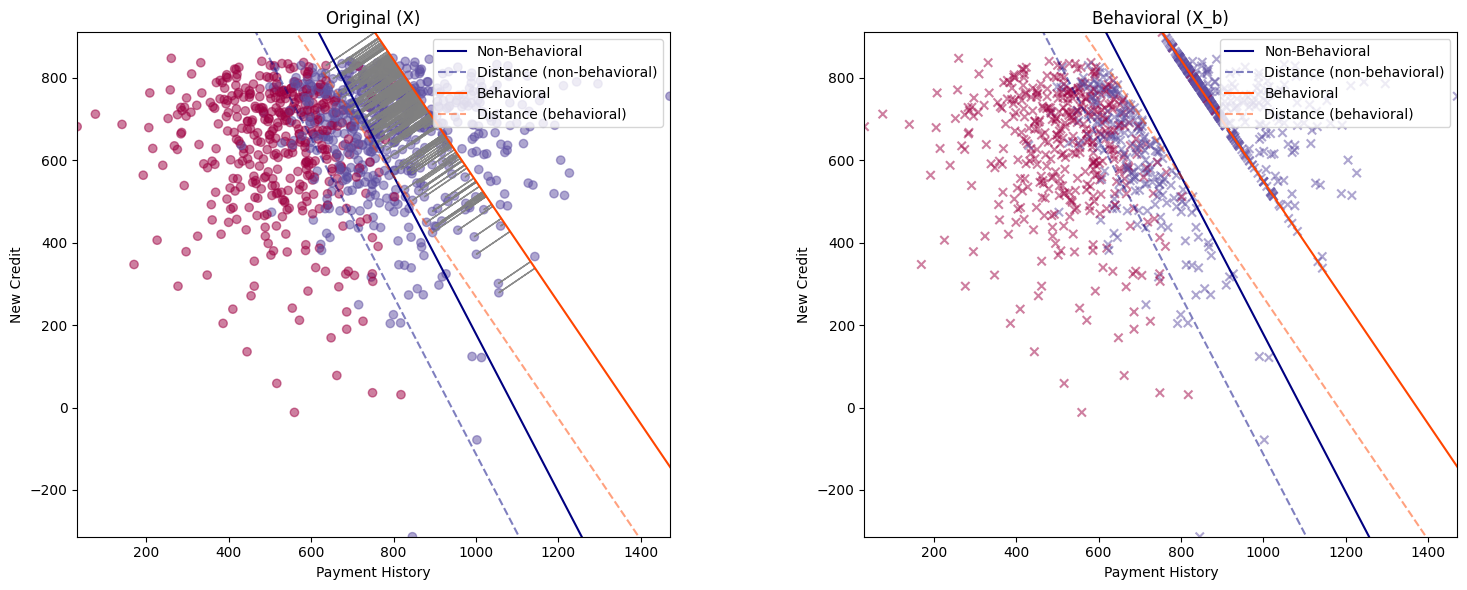

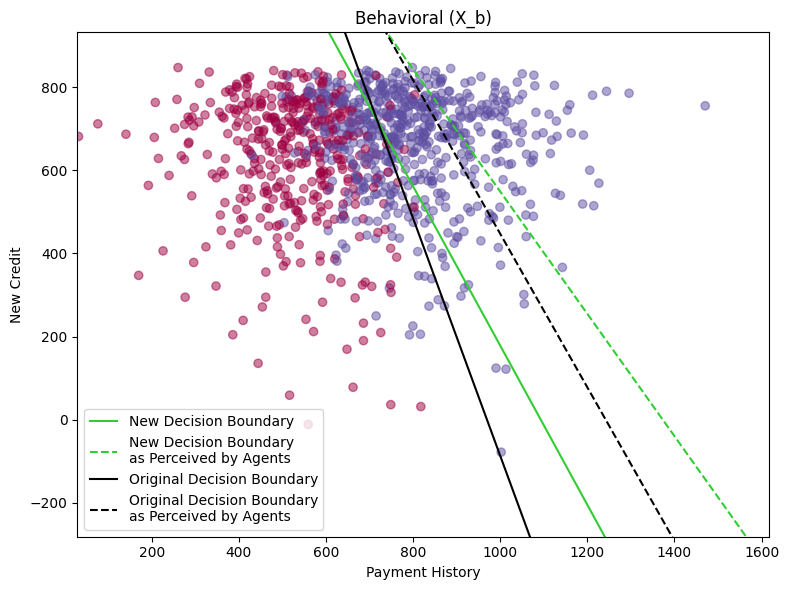

In [153]:
# plot with create_side_by_side_plots_with_arrows(dataset1, dataset2, labels, title1, title2, feature1=feature1, feature2=feature2, mode='NB')
create_side_by_side_plots_with_arrows(X_0, X_b_updates, y_0, 'Original (X)', 'Behavioral (X_b)', beta_vis, threshold_vis, B, gamma, mode='B')


# plot the line separating the new decision boundary on X_b_updates
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X_0[feature1], X_0[feature2], c=y_0, cmap='Spectral', alpha=0.5)
ax.set_xlabel(feature1)
ax.set_ylabel(feature2)
ax.set_title('Behavioral (X_b)')

y_min = min(X_0[feature2])
y_max = max(X_0[feature2])
x_min = min(X_0[feature1])
x_max = max(X_0[feature1])
ax.set_ylim(0.9*y_min, 1.1*y_max)
ax.set_xlim(0.9*x_min, 1.1*x_max)

x_vals = np.array(ax.get_xlim())
y_vals_b = -(threshold_vis + beta_vis[0] * x_vals) / beta_vis[1]
y_vals_og = -(threshold_vis + beta_vis_0[0] * x_vals) / beta_vis_0[1]
y_vals_b_perc = -(threshold_vis + perceived_weights_vis_b[0] * x_vals) / perceived_weights_vis_b[1]
y_vals_og_perc = -(threshold_vis + perceived_weights_vis_0[0] * x_vals) / perceived_weights_vis_0[1]
ax.plot(x_vals, y_vals_b, color='limegreen', label='New Decision Boundary')
ax.plot(x_vals, y_vals_b_perc, '--', color='limegreen', label='New Decision Boundary\nas Perceived by Agents')
ax.plot(x_vals, y_vals_og, color='k', label='Original Decision Boundary')
ax.plot(x_vals, y_vals_og_perc, '--', color='k', label='Original Decision Boundary\nas Perceived by Agents')
ax.legend()
plt.tight_layout()
plt.show()


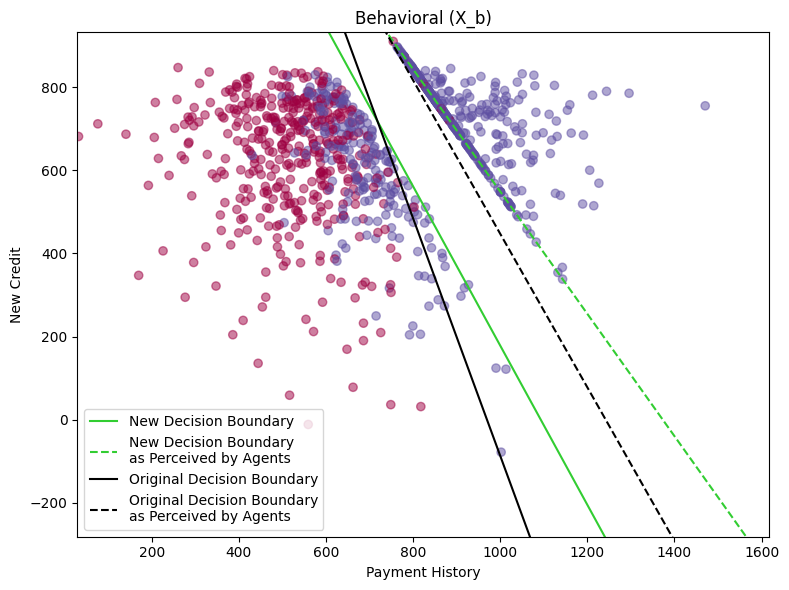

In [154]:
# plot the line separating the new decision boundary on X_b_updates
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X_b_updates[feature1], X_b_updates[feature2], c=y_0, cmap='Spectral', alpha=0.5)
ax.set_xlabel(feature1)
ax.set_ylabel(feature2)
ax.set_title('Behavioral (X_b)')

y_min = min(X_0[feature2])
y_max = max(X_0[feature2])
x_min = min(X_0[feature1])
x_max = max(X_0[feature1])
ax.set_ylim(0.9*y_min, 1.1*y_max)
ax.set_xlim(0.9*x_min, 1.1*x_max)


x_vals = np.array(ax.get_xlim())
y_vals_b = -(threshold_vis + beta_vis[0] * x_vals) / beta_vis[1]
y_vals_og = -(threshold_vis + beta_vis_0[0] * x_vals) / beta_vis_0[1]
y_vals_b_perc = -(threshold_vis + perceived_weights_vis_b[0] * x_vals) / perceived_weights_vis_b[1]
y_vals_og_perc = -(threshold_vis + perceived_weights_vis_0[0] * x_vals) / perceived_weights_vis_0[1]
ax.plot(x_vals, y_vals_b, color='limegreen', label='New Decision Boundary')
ax.plot(x_vals, y_vals_b_perc, '--', color='limegreen', label='New Decision Boundary\nas Perceived by Agents')
ax.plot(x_vals, y_vals_og, color='k', label='Original Decision Boundary')
ax.plot(x_vals, y_vals_og_perc, '--', color='k', label='Original Decision Boundary\nas Perceived by Agents')
ax.legend()
plt.tight_layout()
plt.show()


# Non Behavioral

In [155]:
def update_dataset(X, beta, threshold, B, gamma, mode='actual'):

    X_updated = X.copy()
    for index, row in X_updated.iterrows():
        if mode == 'actual':
            if abs(row @ beta + threshold) <= B:
                if not classifier(row.values, beta, threshold):
                    X_updated.loc[index] = agent_optimization(row.values, beta, threshold, mode=mode)

        elif mode == 'perceived':
            perceived_weights = behavioral(beta, gamma=gamma)
            if abs(row @ perceived_weights + threshold) <= B:
                if not classifier(row.values, perceived_weights, threshold):
                    X_updated.loc[index] = agent_optimization(row.values, beta, threshold, mode=mode, gamma=gamma)

    return X_updated

iterations = 100
B = 100
gamma = 0.3

X_0 = fico_df[['Payment History', 'New Credit']]
y_0 = fico_df['True Label']
beta_vis, threshold_vis = logistic_regression_with_sum_constraint(X_0, y_0)    

for i in range(iterations):
    X_b_updates = X.copy()

    X_b_updates = update_dataset(X_0, beta_vis, threshold_vis, B, gamma, mode='actual')
    beta_new, threshold_new = logistic_regression_with_sum_constraint(X_b_updates, y_0)
    print(f"Iteration {i+1}: Beta coefficients: {beta_new}, Threshold: {threshold_new}")

    if np.linalg.norm(beta_new - beta_vis) < 1e-5:
        break

    beta_vis = beta_new

print(f"Converged after {i+1} iterations.")
print("Beta coefficients:", beta_vis)
print("Threshold:", threshold_vis)

Iteration 1: Beta coefficients: [0.74286817 0.25713181], Threshold: -643.9457510372346
Iteration 2: Beta coefficients: [0.74464138 0.25535861], Threshold: -643.907157486494
Iteration 3: Beta coefficients: [0.74615638 0.25384362], Threshold: -643.874031716872
Iteration 4: Beta coefficients: [0.74738392 0.25261607], Threshold: -643.8516985891769
Iteration 5: Beta coefficients: [0.74832512 0.25167487], Threshold: -643.8424612504938
Iteration 6: Beta coefficients: [0.74901799 0.25098201], Threshold: -643.8348545702937
Iteration 7: Beta coefficients: [0.74951091 0.25048908], Threshold: -643.8296168022235
Iteration 8: Beta coefficients: [0.74986197 0.25013802], Threshold: -643.8288502636551
Iteration 9: Beta coefficients: [0.75010959 0.24989041], Threshold: -643.8285893411531
Iteration 10: Beta coefficients: [0.75028311 0.24971688], Threshold: -643.8285503211115
Iteration 11: Beta coefficients: [0.75040419 0.2495958 ], Threshold: -643.8286021829033
Iteration 12: Beta coefficients: [0.7504886

In [156]:
print("Before optimization:")
TP_0 = 0
FP_0 = 0
for index, row in X_0.iterrows():
    TP_0 += classifier(row.values, beta_vis, threshold_vis) and y_0.loc[index]
    FP_0 += classifier(row.values, beta_vis, threshold_vis) and not y_0.loc[index]   

firm_payoff_0 = TP_0 - FP_0
print(f"True positive: {TP_0}")
print(f"False positive: {FP_0}")
print(f"Firm's payoff: {firm_payoff_0}")


print("\nAfter optimization (Non-Behavioral):")
TP_b = 0
FP_b = 0
for index, row in X_b_updates.iterrows():
    TP_b += classifier(row.values, beta_vis, threshold_vis) and y_0.loc[index]
    FP_b += classifier(row.values, beta_vis, threshold_vis) and not y_0.loc[index]

firm_payoff_b = TP_b - FP_b
print(f"True positive: {TP_b}")
print(f"False positive: {FP_b}")
print(f"Firm's payoff: {firm_payoff_b}")

Before optimization:
True positive: 541
False positive: 59
Firm's payoff: 482

After optimization (Non-Behavioral):
True positive: 598
False positive: 220
Firm's payoff: 378


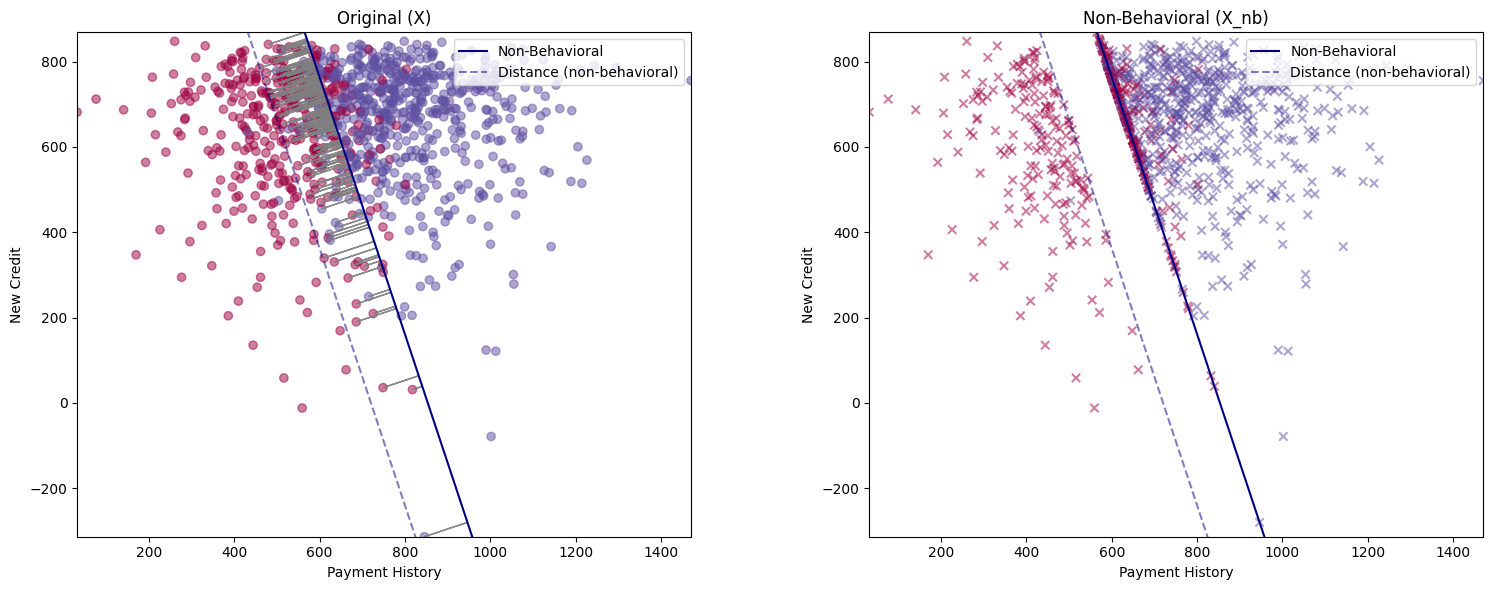

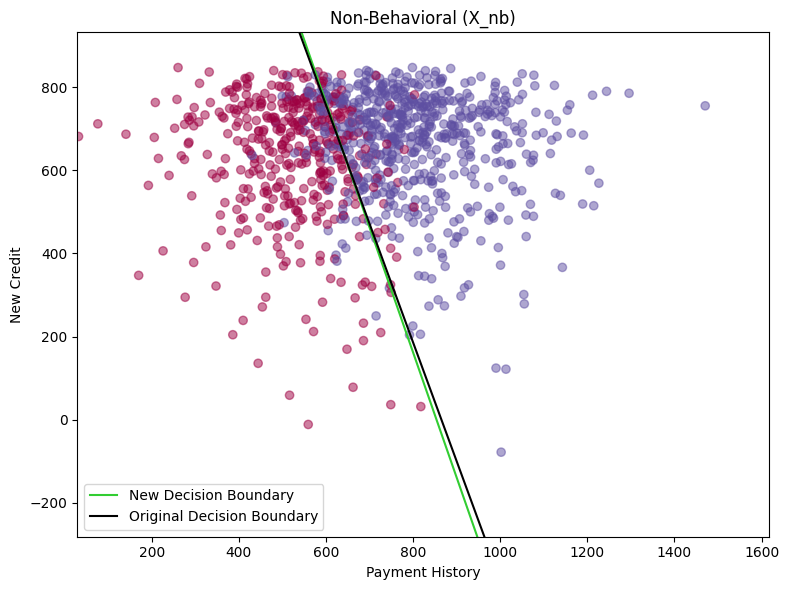

In [157]:
# plot with create_side_by_side_plots_with_arrows(dataset1, dataset2, labels, title1, title2, feature1=feature1, feature2=feature2, mode='NB')
create_side_by_side_plots_with_arrows(X_0, X_b_updates, y_0, 'Original (X)', 'Non-Behavioral (X_nb)', beta_vis, threshold_vis_0, B, gamma, mode='NB')


# plot the line separating the new decision boundary on X_b_updates
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X_0[feature1], X_0[feature2], c=y_0, cmap='Spectral', alpha=0.5)
ax.set_xlabel(feature1)
ax.set_ylabel(feature2)
ax.set_title('Non-Behavioral (X_nb)')


x_vals = np.array(ax.get_xlim())
y_vals_nb = -(threshold_vis + beta_vis[0] * x_vals) / beta_vis[1]
y_vals_og = -(threshold_vis + beta_vis_0[0] * x_vals) / beta_vis_0[1]
ax.plot(x_vals, y_vals_nb, color='limegreen', label='New Decision Boundary')
ax.plot(x_vals, y_vals_og, color='k', label='Original Decision Boundary')

y_min = min(X_0[feature2])
y_max = max(X_0[feature2])
x_min = min(X_0[feature1])
x_max = max(X_0[feature1])
ax.set_ylim(0.9*y_min, 1.1*y_max)
ax.set_xlim(0.9*x_min, 1.1*x_max)

ax.legend()
plt.tight_layout()
plt.show()
